# population and hk total generated per day

Model Summary:
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           3.064e+04   6666.447      4.597      0.000    1.66e+04    4.46e+04
HK total population (mid-year)    -0.0020      0.001     -2.151      0.045      -0.004   -4.68e-05

R-squared: 0.2046


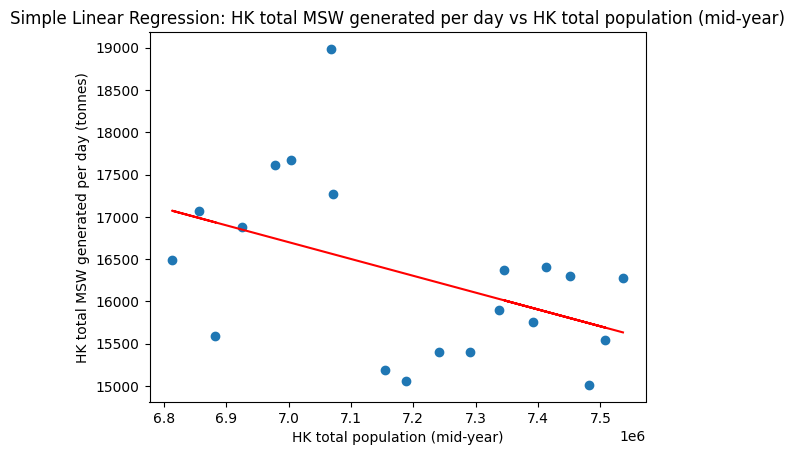

In [1]:
# !pip install pandas numpy matplotlib scikit-learn statsmodels openpyxl
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix

from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm

import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel("../General Stats_G@C_clean.xlsx")

### Simple Linear Regression: HK total MSW generated per day vs HK total population (mid-year)

# Prepare data
# Make sure the relevant columns are numeric
df["HK total population (mid-year)"] = pd.to_numeric(
    df["HK total population (mid-year)"], errors="coerce"
)
df["HK total MSW generated (tonnes)"] = pd.to_numeric(
    df["HK total MSW generated (tonnes)"], errors="coerce"
)

# Add number of days in each year (leap years: 2004, 2008, 2012, 2016, 2020, 2024)
leap_years = [2004, 2008, 2012, 2016, 2020, 2024]
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["days_in_year"] = df["Year"].apply(
    lambda y: 366 if pd.notna(y) and int(y) in leap_years else (365 if pd.notna(y) else np.nan)
)

# Compute HK total MSW generated per day (tonnes/day)
df["HK MSW generated per day (tonnes)"] = (
    df["HK total MSW generated (tonnes)"] / df["days_in_year"]
)

# Keep only rows where both variables are available
mask = (
    df["HK total population (mid-year)"].notna()
    & df["HK MSW generated per day (tonnes)"].notna()
)
X_pop = df.loc[mask, ["HK total population (mid-year)"]]
y_msw_per_day = df.loc[mask, "HK MSW generated per day (tonnes)"]

# Fit model using sklearn for predictions
lin_reg_pop = LinearRegression()
lin_reg_pop.fit(X_pop, y_msw_per_day)

# Fit model using statsmodels for statistical tests
X_pop_sm = sm.add_constant(X_pop.astype(float))  # Add constant term for intercept
model_pop = sm.OLS(y_msw_per_day.astype(float), X_pop_sm)
results_pop = model_pop.fit()

# Predictions for plotting
y_pred_msw_per_day = lin_reg_pop.predict(X_pop)

print("Model Summary:")
print(results_pop.summary().tables[1])  # Print coefficient statistics
print(f"\nR-squared: {results_pop.rsquared:.4f}")

# Plot
plt.scatter(X_pop, y_msw_per_day)
plt.plot(X_pop, y_pred_msw_per_day, color='red')
plt.xlabel('HK total population (mid-year)')
plt.ylabel('HK total MSW generated per day (tonnes)')
plt.title('Simple Linear Regression: HK total MSW generated per day vs HK total population (mid-year)')
plt.show()


**Population coefficient ($\hat \beta_1$) ≈ -0.0020 (p = 0.045 < 0.05)**  

- There is a **statistically significant but negative association** between Hong Kong’s mid-year population size and the total MSW generated per day. As population increases, the model suggests that **daily total MSW generated tends to decrease slightly**, which implies that other forces (e.g. waste-reduction policies, behavioural change, or economic structure) have offset the effect of population growth on total waste.  

- The **R-squared is modest (~0.20)**, meaning population explains only about **20% of the variation** in daily MSW generation; **most of the variation is driven by other factors** such as consumption patterns, recycling and waste-charging policies, and broader economic or social changes.
